<a href="https://colab.research.google.com/github/csabiu/astronomy/blob/main/Astro_magnitudes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install some packages and import them

In [1]:
pip install astroquery

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.5 MB 2.1 MB/s 
     |████████████████████████████████| 832 kB 51.0 MB/s 
     |████████████████████████████████| 48 kB 4.1 MB/s 
     |████████████████████████████████| 4.0 MB 51.7 MB/s 


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import (SkyCoord, Distance, Galactic, 
                                 EarthLocation, AltAz)
import astropy.coordinates as coord
from astropy.time import Time
from astropy import units as u
from astropy.coordinates import AltAz
from astropy.io import fits
from astropy.table import QTable
from astropy.utils.data import download_file
from astroquery.gaia import Gaia


launch SQL job on GAIA archive 

see the below website for all available columns and descriptions:

https://gea.esac.esa.int/archive/ 

In [89]:
job = Gaia.launch_job_async("SELECT gaia.source_id,gaia.ra,gaia.dec,gaia.l,gaia.parallax_over_error,gaia.b,gaia.parallax, gaia.phot_bp_mean_mag, gaia.phot_rp_mean_mag,gaia.parallax_error,gaia.phot_g_mean_mag,gaia.bp_rp, cep.pf,cep.pf_error, gaia.ag_gspphot "
                        "FROM gaiadr3.gaia_source AS gaia "
                        "JOIN gaiadr3.vari_cepheid AS cep "
                        "ON gaia.source_id=cep.source_id "
                        "WHERE gaia.parallax_over_error>5 "
                        "AND gaia.ag_gspphot IS NOT NULL ",
                      dump_to_file=True, output_format='votable',)

In [90]:
#load results
r = job.get_results()

ra=np.asarray(r['ra'].value)
dec=np.asarray(r['dec'].value)
par=np.asarray(r['parallax'].value)           # parallax [milliarcsec]
par_err=np.asarray(r['parallax_error'].value)
ex=np.asarray(r['ag_gspphot'].value)
pf=np.asarray(r['pf'].value)                  # period days
pf_err=np.asarray(r['pf_error'].value)

magG=np.asarray(r['phot_g_mean_mag'].value)   # apparent magnitude
magBP=np.asarray(r['phot_bp_mean_mag'].value) # blue apparent magnitude
magRP=np.asarray(r['phot_rp_mean_mag'].value) # red apparent magnitude

W = magG - 1.90*(magBP - magRP) #corrected magnitude

sn=par/par_err 

print('dr3 has ',par.shape,' cepheids')

b=np.asarray(r['b'].value)
l=np.asarray(r['l'].value)

dist=Distance(parallax=par*u.mas,allow_negative=True).value/1E3
dist

dr3 has  (1101,)  cepheids


array([10.53827442,  6.40862357,  7.827217  , ...,  3.25096572,
        0.95426647,  2.66250755])

Plot the position of cephieds 

showing the positions of LMC and SMC, M31, M33

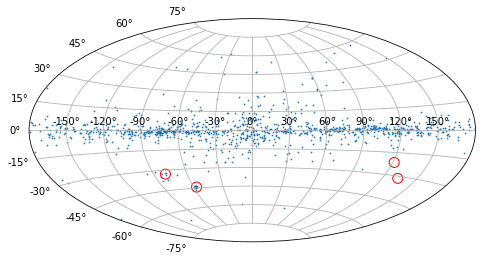

In [91]:
lmc=SkyCoord.from_name('LMC')
smc=SkyCoord.from_name('SMC')
tri=SkyCoord.from_name('M33')
m31=SkyCoord.from_name('M31')

gal = SkyCoord(l, b, frame='galactic', unit=u.deg)
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='aitoff')
ax.grid(True)
ax.scatter(gal.l.wrap_at('180d').radian, gal.b.radian,s=0.5)
ax.scatter(lmc.galactic.l.wrap_at('180d').radian, lmc.galactic.b.radian,s=100,facecolors='none', edgecolors='r')
ax.scatter(smc.galactic.l.wrap_at('180d').radian, smc.galactic.b.radian,s=100,facecolors='none', edgecolors='r')
ax.scatter(tri.galactic.l.wrap_at('180d').radian, tri.galactic.b.radian,s=100,facecolors='none', edgecolors='r')
ax.scatter(m31.galactic.l.wrap_at('180d').radian, m31.galactic.b.radian,s=100,facecolors='none', edgecolors='r')

1. compute the seperation between our stars and LMC, SMC, Triangulum Galaxy and M31 Andromeda Galaxy
2. mask out any stars less than 10deg from either MC
3. mask out the stars close to the galactic equator

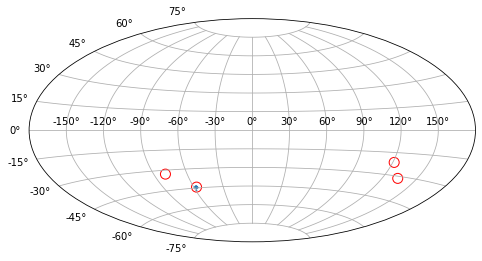

In [101]:
cep = SkyCoord(ra, dec, frame='icrs', unit=u.deg)

sep1 = cep.separation(lmc)
sep2 = cep.separation(smc)
sep3 = cep.separation(tri)
sep4 = cep.separation(m31)
msk=np.where((sep1.deg>10.0) & (sep2.deg>10.0) & (sep3.deg>10.0) & (sep4.deg>10.0) & (np.abs(gal.b.deg)>5.0) & (par>0.0))
msk=np.where((sep2.deg<10.0))


fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='aitoff')
ax.grid(True)
ax.scatter(gal[msk].l.wrap_at('180d').radian, gal[msk].b.radian,s=0.5)
ax.scatter(lmc.galactic.l.wrap_at('180d').radian, lmc.galactic.b.radian,s=100,facecolors='none', edgecolors='r')
ax.scatter(smc.galactic.l.wrap_at('180d').radian, smc.galactic.b.radian,s=100,facecolors='none', edgecolors='r')
ax.scatter(tri.galactic.l.wrap_at('180d').radian, tri.galactic.b.radian,s=100,facecolors='none', edgecolors='r')
ax.scatter(m31.galactic.l.wrap_at('180d').radian, m31.galactic.b.radian,s=100,facecolors='none', edgecolors='r')

In [112]:
msk=np.where( (sep3.deg<10.0))


In [113]:
#M=magG[msk]+5*np.log10(par[msk]/1000.)+5
#M
#M=W[msk]+5. - 5.*np.log10(dist[msk]*1000)
M=magG[msk] - ex[msk]  + 5 * np.log10(par[msk] ) - 10
M

array([], dtype=float64)

In [ ]:
r = job.get_results()

ra=np.asarray(r['ra'].value)
dec=np.asarray(r['dec'].value)
par=np.asarray(r['parallax'].value)
par_err=np.asarray(r['parallax_error'].value)
magG=np.asarray(r['phot_g_mean_mag'].value)
magBP=np.asarray(r['phot_bp_mean_mag'].value)
magRP=np.asarray(r['phot_rp_mean_mag'].value)
ex=np.asarray(r['ag_gspphot'].value)
pf=np.asarray(r['pf'].value)
pf_err=np.asarray(r['pf_error'].value)

W = magG - 1.90*(magBP - magRP) 

#msk=np.where((sep.deg>10.0) & (sep2.deg>10.0) & (sn>4.0))
#msk=par>0.0


#M=mag[msk]+5*np.log10(par[msk]/1000.+1.)
#M=mag+5. - 5.*np.log10(dist.pc)#-ex[msk]
#M.shape

Text(0, 0.5, '$M_G$')

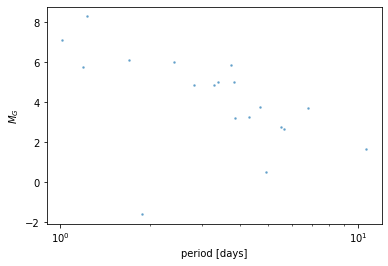

In [107]:
plt.scatter(pf[msk],M,s=2.5,alpha=0.5)
plt.xscale('log')
plt.xlabel('period [days]')
plt.ylabel(r'$M_G$')
#plt.xlim([0.6,40])
#plt.ylim([9,21])

Can you make the HR disgram from this GAIA data?

In [60]:
job = Gaia.launch_job_async("SELECT TOP 5000 source_id,ra,dec,l,b,parallax, phot_bp_mean_mag, parallax_over_error,phot_rp_mean_mag,parallax_error, phot_g_mean_mag,bp_rp, ag_gspphot, bp_rp, ebpminrp_gspphot "
                        "FROM gaiadr3.gaia_source "
                        "WHERE parallax>0.0"
                        "AND parallax_over_error>5"
                        "AND ag_gspphot IS NOT NULL",
                      dump_to_file=True, output_format='votable',)


In [61]:
r = job.get_results()

ra=np.asarray(r['ra'].value)
dec=np.asarray(r['dec'].value)
par=np.asarray(r['parallax'].value)                      # parallax
par_err=np.asarray(r['parallax_error'].value)            # parallax error
magG=np.asarray(r['phot_g_mean_mag'].value)              # magnitude
ex=np.asarray(r['ag_gspphot'].value)                     # mag extinction correction
bp_rp=np.asarray(r['bp_rp'].value)                       # colour index b-r
ebpminrp_gspphot=np.asarray(r['ebpminrp_gspphot'].value) # color excess (correction)

